# Building A Linear Regression with PySpark and MLlib

Apache Spark has become one of the most commonly used and supported open-source tools for machine learning and data science.
In this post, I’ll help you get started using Apache Spark’s spark.ml Linear Regression for predicting rental bike. Data is from "UCI Machine learning repository : Bike sharing Data set". In this example below we use the day data set.

### Attribute information

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark_session = SparkSession.builder.getOrCreate()

## Load the data

In [3]:
bike_sharing = spark_session.read.csv("./Documents/MachineLearning/BikeSharing/day.csv", header=True)

## Data Exploration

In [4]:
bike_sharing.limit(5).toPandas()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


### Print Schema in a tree format.

In [5]:
bike_sharing.printSchema()

root
 |-- instant: string (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: string (nullable = true)
 |-- yr: string (nullable = true)
 |-- mnth: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- workingday: string (nullable = true)
 |-- weathersit: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- atemp: string (nullable = true)
 |-- hum: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- casual: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- cnt: string (nullable = true)



Here all variables are typed "string" , then we have to convert them in convenient types (integer or double)

features selections and types

In [6]:
bike_sharing01 = bike_sharing.select (
    bike_sharing.season.astype("int"),
    bike_sharing.yr.astype("int"),
    bike_sharing.mnth.astype("int"),
    bike_sharing.holiday.astype("int"),
    bike_sharing.weekday.astype("int"),
    bike_sharing.workingday.astype("int"),
    bike_sharing.weathersit.astype("int"),
    bike_sharing.temp.astype("double"),
    bike_sharing.atemp.astype("double"),
    bike_sharing.hum.astype("double"),
    bike_sharing.windspeed.astype("double"),
    bike_sharing.cnt.astype("int").alias("label")
)

In [7]:
bike_sharing01.limit(5).toPandas()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,label
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [8]:
bike_sharing01.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
season,731,2.496580027359781,1.1108070927726252,1,4
yr,731,0.5006839945280438,0.5003418803818265,0,1
mnth,731,6.519835841313269,3.451912787256252,1,12
holiday,731,0.028727770177838577,0.16715474262247393,0,1
weekday,731,2.997264021887825,2.004786917944481,0,6
workingday,731,0.6839945280437757,0.4652333866777039,0,1
weathersit,731,1.3953488372093024,0.5448943419593665,1,3
temp,731,0.49538478850889184,0.18305099611148876,0.0591304,0.861667
atemp,731,0.47435398864569067,0.1629611783863112,0.0790696,0.840896


### independancy of variables
Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. 
#### NB : PySpark doesn't have any plotting functionality (yet). If you want to plot something, you can bring the data out of the Spark Context and into your "local" Python session, where you can deal with it using any of Python's many plotting libraries


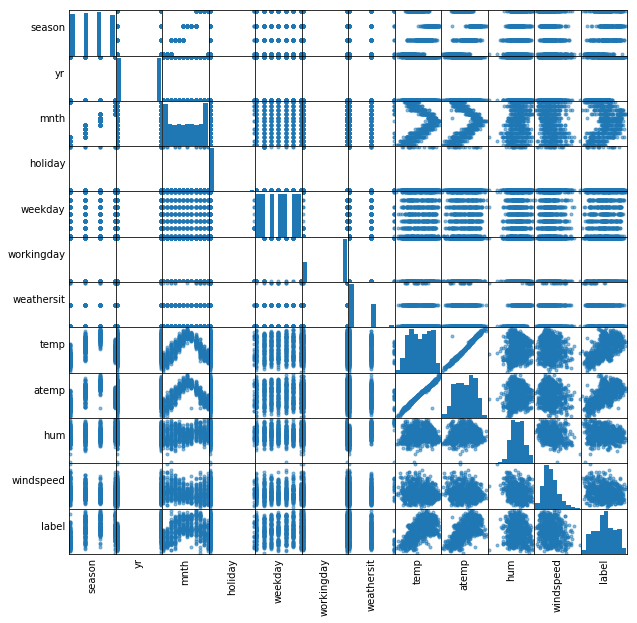

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
axs = pd.scatter_matrix(bike_sharing01.toPandas(), figsize=(10, 10))
n = len(bike_sharing01.toPandas().columns) ## .toPandas to bring data out of the Spark context
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
plt.show()

### using seabon to plot pairplot easly

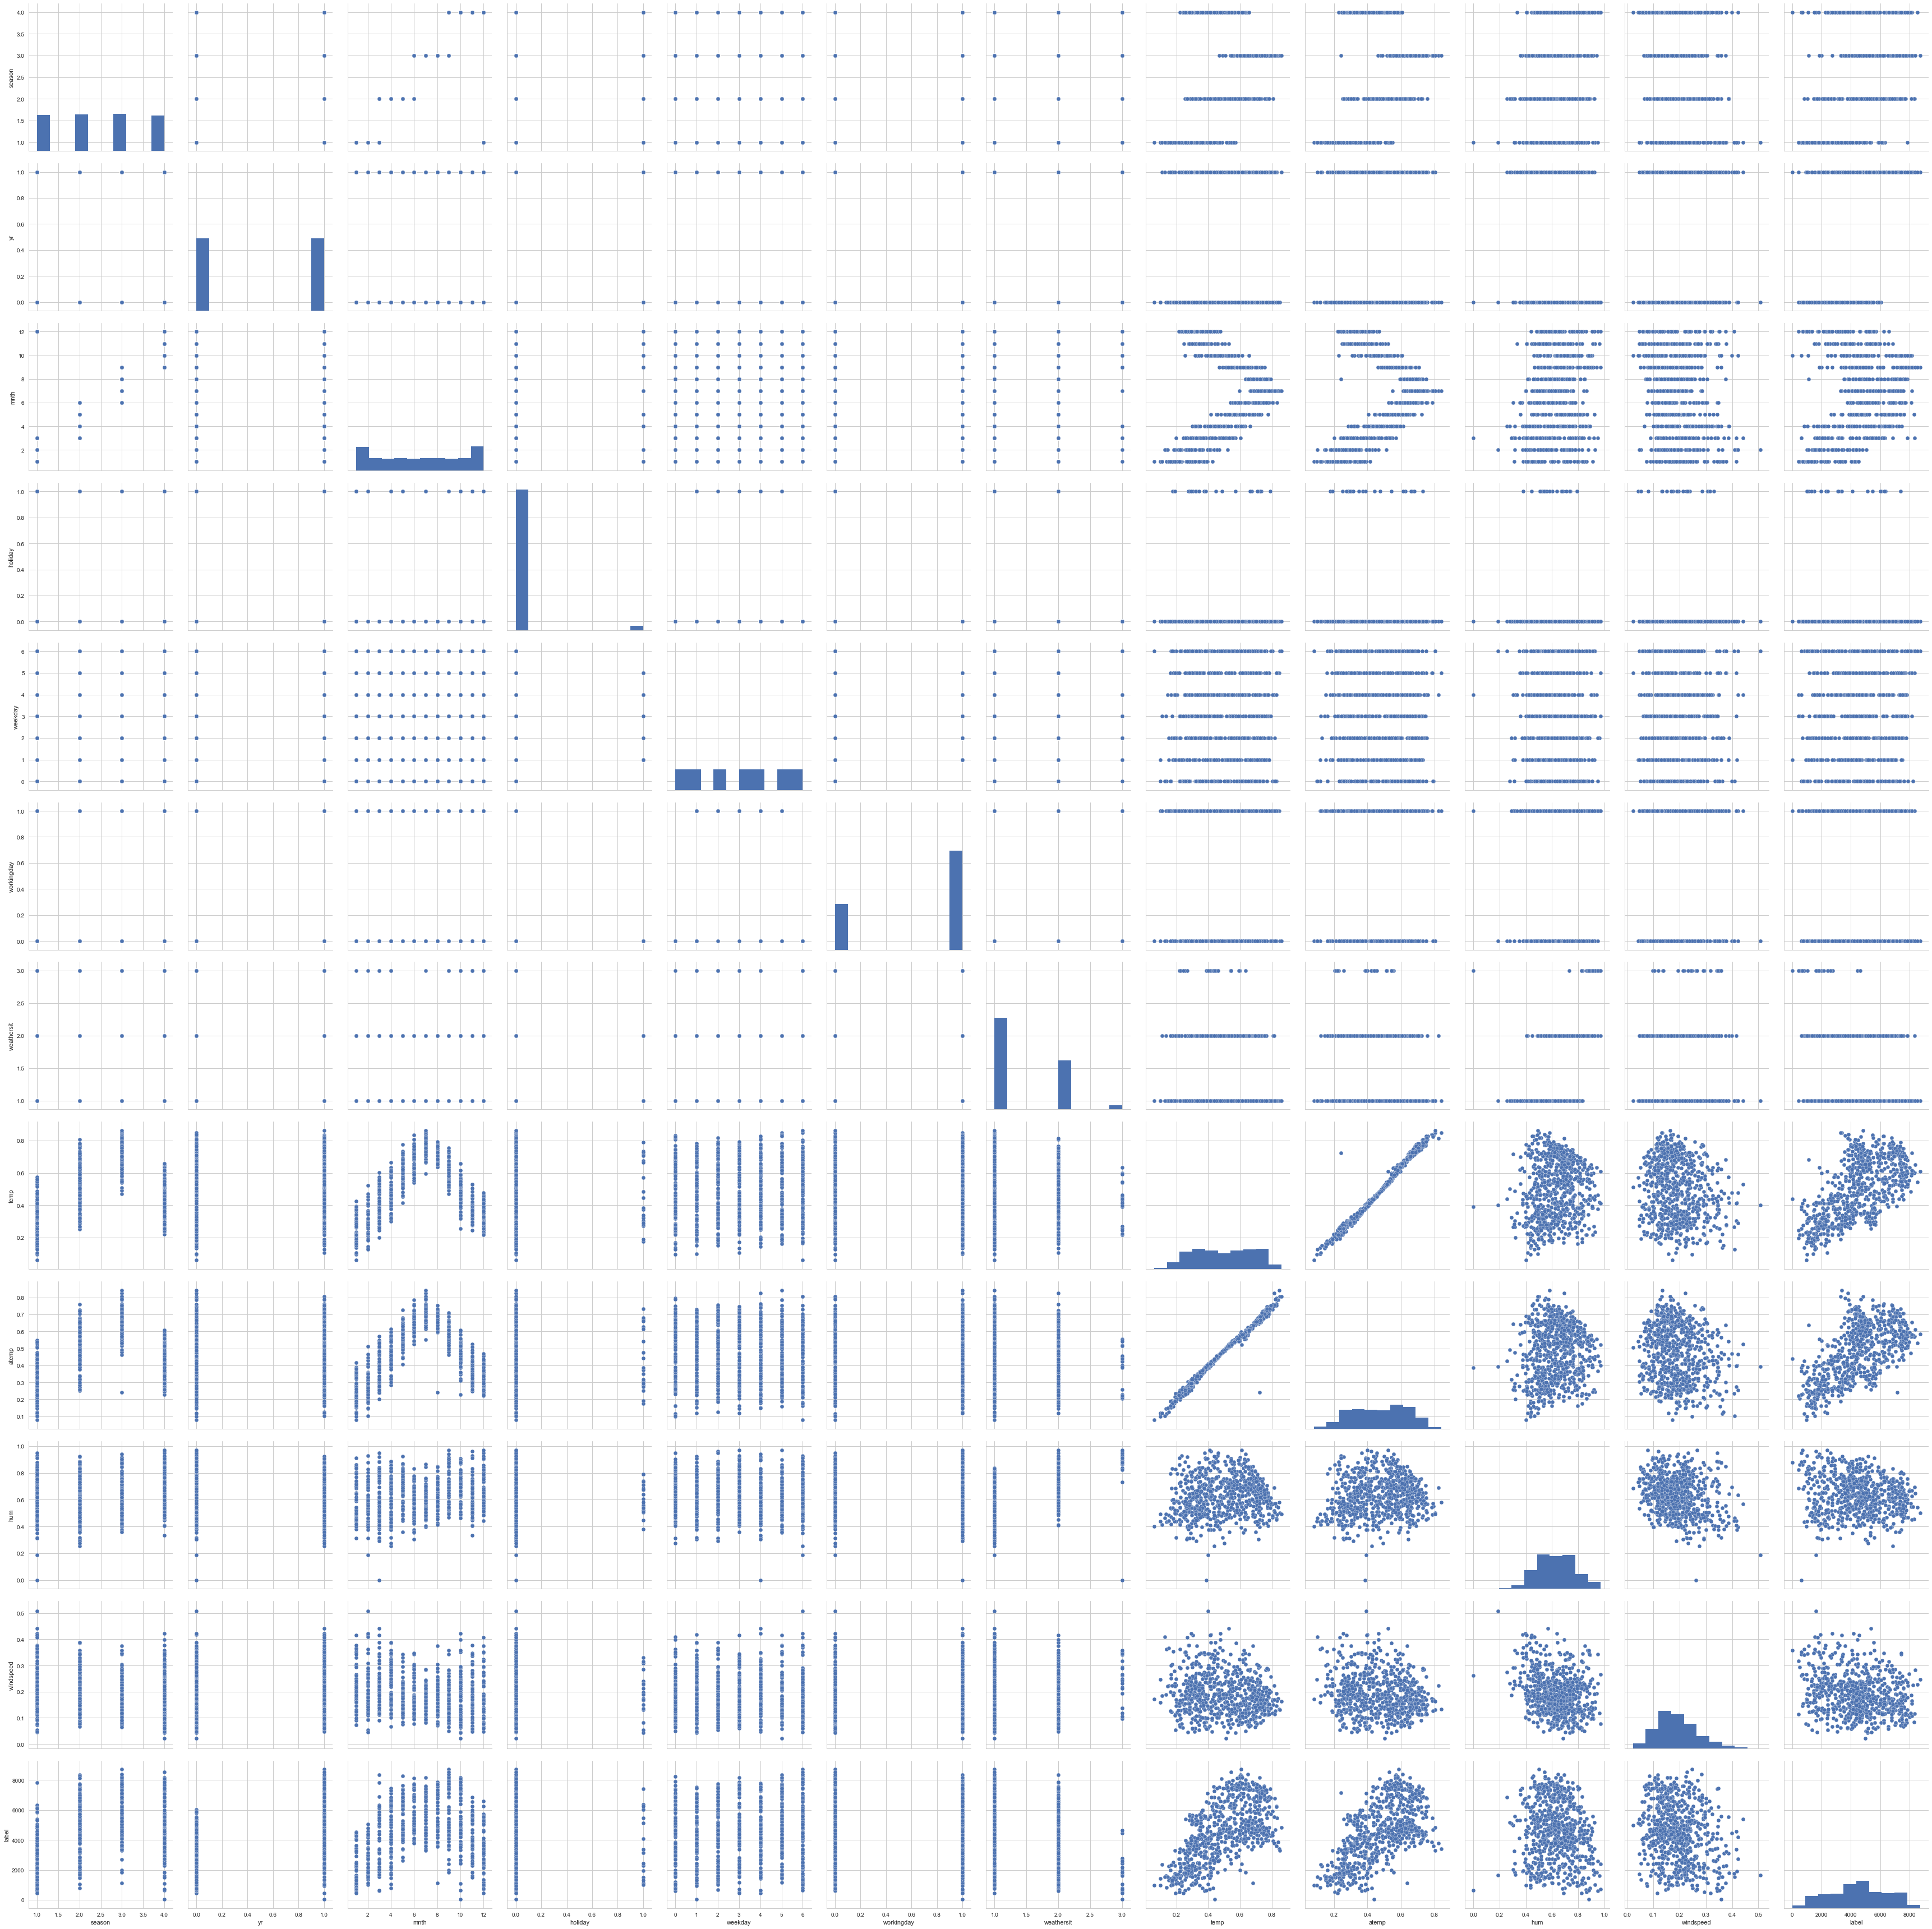

In [11]:
import numpy as np
import seaborn as sns
sns.set (style='whitegrid', context='notebook')
sns.pairplot(bike_sharing01.toPandas(), size=4)
plt.show()

#### Here is abvious that there is a correlation between  temp and atemp variables.

In [12]:
import six
for i in bike_sharing01.columns:
    if not( isinstance(bike_sharing01.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to label for ", i, bike_sharing01.stat.corr('label',i))

Correlation to label for  season 0.40610037079863526
Correlation to label for  yr 0.5667097078680867
Correlation to label for  mnth 0.2799771122192702
Correlation to label for  holiday -0.06834771589248398
Correlation to label for  weekday 0.06744341241063072
Correlation to label for  workingday 0.06115606306052115
Correlation to label for  weathersit -0.29739123883466345
Correlation to label for  temp 0.6274940090334915
Correlation to label for  atemp 0.6310656998491827
Correlation to label for  hum -0.1006585621371548
Correlation to label for  windspeed -0.2345449974216706
Correlation to label for  label 1.0


The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation and when coefficients close to zero mean that there is no linear correlation.
Finally, we are going to drop atemp (Normalized feeling temperature in Celsius) and keep all the remain variables.

## MACHINE LEARNING

#### We are going to test 3 models : Linear Regression, Decision Tree Regression anf Gradient-Boosted Decision Tree

## Prepare data for Machine Learning

#### features vector
VectorAssembler constructs Vector from raw feature columns (Most ml algorithms take features in the form of vector)

In [13]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler()\
    .setInputCols(["season",
                  "yr",
                  "mnth",
                  "holiday",
                  "weekday",
                  "workingday",
                  "weathersit",
                  "temp",
                  "hum",
                  "windspeed"])\
    .setOutputCol("features")
    

#### Transformers
    Transform one dataframe to another dataframe. 

In [14]:
bike_sharing_df = assembler.transform(bike_sharing01)
bike_sharing_df.limit(5).toPandas()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,label,features
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.344167, ..."
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.363478, ..."
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.196364, ..."
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.2, 0.590..."
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, ..."


#### keep features and label only

In [15]:
bike_sharing_df=bike_sharing_df.select("features", "label")
bike_sharing_df.limit(5).toPandas()

,features,label
0,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.344167, ...",985
1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.363478, ...",801
2,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.196364, ...",1349
3,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.2, 0.590...",1562
4,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, ...",1600


### Split data 

In [16]:
train, test = bike_sharing_df.randomSplit([0.7, 0.3])

## train a linear regression in spark ML

In [17]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()# here we use default parameters
lr_model = lr.fit(train)

In [18]:
train01 = lr_model.transform(train)
train01.limit(5).toPandas()

,features,label,prediction
0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0965217,...",986,868.179956
1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.138333, ...",822,761.148589
2,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.231667, ...",1204,1682.284673
3,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.363478, ...",801,1403.712046
4,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.2, 0.590...",1562,1727.019773


## Evaluation of the Linear Regression model

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
evaluator.evaluate(train01, {evaluator.metricName:"r2"})

0.7852865796185354

#### R squared at 0.78 indicates that in our model, approximate 78% of the variability in “label” can be explained using the model.

In [20]:
evaluator.evaluate(train01, {evaluator.metricName:"rmse"})

887.6151474888286

#### RMSE measures the differences between predicted values by the model and the actual values

In [21]:
import pyspark.sql.functions as f
train01.select(f.abs(f.col('label')-f.col("prediction")).alias("diff"))\
    .limit(5).toPandas()

,diff
0,117.820044
1,60.851411
2,478.284673
3,602.712046
4,165.019773


### check thye accuracy 

In [22]:
train01.select(f.abs(f.col('label')-f.col("prediction")).alias("diff"))\
        .select(f.when(f.col("diff")<500, 1).otherwise(0).alias("is_accurate"))\
        .limit(5).toPandas()

,is_accurate
0,1
1,1
2,1
3,0
4,1


In [23]:
train01.select(f.abs(f.col('label')-f.col("prediction")).alias("diff"))\
        .select(f.when(f.col("diff")<500, 1).otherwise(0).alias("is_accurate"))\
        .agg(f.mean("is_accurate").alias("accuracy"))\
        .limit(5).toPandas()

,accuracy
0,0.484909


### Test the model on the test data set

In [24]:
lr_predictions = lr_model.transform(test)
#lr_predictions.select("prediction","label","features").show(5)
lr_predictions.select("label","prediction","features").limit(5).toPandas()



,label,prediction,features
0,1096,1740.821607,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.216522, ..."
1,1416,1224.109126,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0973913,..."
2,1321,1321.910068,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.150833, ..."
3,1349,1519.066530,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.196364, ..."
4,1501,863.628309,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.180833, ..."


### Evaluate the linear model on the test data set

In [26]:
#from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_r2.evaluate(lr_predictions))

R Squared (R2) on test data = 0.822369


In [27]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 831.623


## Decision tree regression

In [28]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 856.913


In [29]:
dt_evaluator_r2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator_r2.evaluate(dt_predictions)
print("R squared on test data = %g" % r2)

R squared on test data = 0.811402


In [30]:
dt_model.featureImportances

SparseVector(10, {0: 0.0941, 1: 0.354, 2: 0.0233, 5: 0.0029, 6: 0.0337, 7: 0.4455, 8: 0.0268, 9: 0.0196})

#### Apparently, the number temperature is the most important feature to predict the number of rental bike in our data.

## Gradient-boosted tree regression

In [31]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('label','prediction', 'features').limit(5).toPandas()

,label,prediction,features
0,1096,1041.675037,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.216522, ..."
1,1416,1339.360902,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0973913,..."
2,1321,982.313283,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.150833, ..."
3,1349,982.313283,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.196364, ..."
4,1501,1080.477280,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.180833, ..."


In [32]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_gbt = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE)on test data done by the gradient-boosted tree regression = %g" % rmse_gbt)

Root Mean Squared Error (RMSE)on test data done by the gradient-boosted tree regression = 779.826


In [33]:
gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2_gbt = gbt_evaluator_r2.evaluate(gbt_predictions)
print("R squared on test data done by the gradient-boosted tree regression = %g" % r2_gbt)

R squared on test data done by the gradient-boosted tree regression = 0.843807


### Given models above, gradient boosted tree regression performed a little bit better  on our data.